# Plan of Action

**Our age prediction CNN model shall be defined and trained by**:
1. Importing **training and test datasets** from Google Drive Input Sub-folder
2. **Training dataset is already augmented** and has 234,000 images
3. **Greyscaling images** instead of using RGB color images
4. Defining our intuitively **distributed classes of age-ranges**
5. Using **60 epochs** on our **optimized CNN Architecture**, comprising of:
    - an input *Conv2D* layer (with 32 filters) paired with an *AveragePooling2D* layer,
    - 3 pairs of *Conv2D* (with 64, 128 & 256 filters) and *AveragePooling2D* layers,
    - a *GlobalAveragePooling2D* layer,
    - 1 *Dense* layer with 132 nodes, and
    - an output *Dense* layer with 7 nodes.

# Mount Google Drive & Imports

In [ ]:
#@title Mount Google Drive {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torchvision import datasets, transforms

import tensorflow as tf

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:

#@title Check for GPU

# Testing to ensure GPU is being utilized
# Ensure that the Runtime Type for this notebook is set to GPU
# If a GPU device is not found, change the runtime type under: Runtime>> Change runtime type>> Hardware accelerator>> GPU
# and run the notebook from the beginning again.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

## Import Dataset

In [ ]:
'''#IMPORT CROPPED IMAGES

from google.colab import drive
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/our_cropped_images.zip'

# Destination directory where you want to extract the contents
extracted_dir_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/good_images'

# Create the destination directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Folder unzipped successfully.")
'''

In [ ]:
#IMPORT CELEBRITIES DICTIONARY

# Path to the Python file containing the dictionary
# celebs_path = {'nuria':}

py_file_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/celebrities.py'


# Read the Python file and save the code into a variable
with open(py_file_path, 'r') as file:
    code = file.read()

# Now you can execute the code to get the dictionary
exec_globals = {}
exec(code, exec_globals)

# Extract the dictionary from the executed code
celebrities_dict = exec_globals['celebrities']
print(celebrities_dict)

{'Channing Tatum': 1, 'Christina Applegate': 2, 'Richard E. Grant': 3, 'S. Epatha Merkerson': 4, 'Farah Fath': 5, 'Jim Beaver': 6, 'Cheryl Hines': 7, 'Michael Vartan': 8, 'Hayden Christensen': 9, 'Laurence Fishburne': 10, 'KathrinJoosten': 11, 'PatrickWarburton': 12, 'Jamie Lee Curtis': 13, 'Jason Judeikis': 14, 'Billy Burke': 15, 'Robert Pattinson': 16, 'Melissa Egan': 17, 'Morena Baccarin': 18, 'Jolene Blalock': 19, 'Matthew Lillard': 20, 'Alicia Goranson': 21, 'Jennie Garth': 22, 'Wanda De Jesus': 23, 'Tracey Bregman': 24, 'Tracey Gold': 25, 'Brendan Fraser': 26, 'Kellan Lutz': 27, 'John Travolta': 28, 'Pierce Brosnan': 29, 'Jasmine Guy': 30, 'Swoosie Kurtz': 31, 'Diego Luna': 32, 'Danny Glover': 33, 'David Cross': 34, 'Farrah Fawcet': 35, 'Paul Walker': 36, 'Matt Long': 37, 'Andy Garcia': 38, 'Casey Affleck': 39, 'Carla Gallo': 40, 'James Brolin': 41, 'Christian Bale': 42, 'Nadia Bjorlin': 43, 'Valerie Bertinelli': 44, 'Alec Baldwin': 45, 'Tamara Braun': 46, 'Andy Serkis': 47, 'Jac

## Resize images

In [ ]:
'''resized_folder_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/m_resized_imgs'
#folder_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/cropped_images/'
folder_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/cropped_images'
#M: vaig pujar la carpeta amb imatges cropped a mà, però no ho he executat encara. És la que es diu 'cropped_images'

if not os.path.exists(resized_folder_path):
    os.makedirs(resized_folder_path)

target_size = (50, 50)
# he fet resize a 50x50 pq n'he vist algunes de 53x53, per deixar un marge

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
        image_path = os.path.join(folder_path, filename)
        # Open the image
        img = Image.open(image_path)
        # Resize the image
        resized_img = img.resize(target_size, Image.ANTIALIAS)
        # Save the resized image to the new folder
        resized_img.save(os.path.join(resized_folder_path, filename))

print("Image resizing complete.")'''

<ipython-input-7-6911e5bb559f>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(target_size, Image.ANTIALIAS)


Image resizing complete.


## Create dataframe that joins image paths with corresponding label

In [ ]:
from ast import Name
#IMPORTAR IMAGE_PATHS + LABELS
# M: He posat primer el resize, i despres aquí crear el dataframe

resized_folder_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/Data/cropped_images'
input_path = resized_folder_path
# List all files in the folder
files = os.listdir(input_path)

# Initialize an empty list to store the image paths
image_paths = []
labels =[]
# Iterate over the files in the folder

for file in files:
  # Check if the file is an image
  if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
    # Construct the full path to the image file
    image_path = os.path.join(input_path, file)

    # Append the image path to the list
    image_paths.append(image_path)

    #HE FET AIXO AIXI PERQ NHI HA QUE TENEN CROPPED AL NOM MES D'UNA VEGADA!!!!
    parts = file.split("_")
    name_index = None

    # Find the index where the name starts
    for i, part in enumerate(parts):
        if part.startswith("cropped"):
            continue
        else:
            name_index = i
            break

    # Extract the name from the parts
    name = parts[name_index]

    labels.append(celebrities_dict[name])

# Create a DataFrame with the image paths
df = pd.DataFrame({'image_path': image_paths,"id":labels})
df = df.astype({'id':int})

print('Dataframe correctly created.')


Dataframe correctly created.


In [ ]:
df[df.id == 75].head()

,image_path,id
1875,/content/drive/MyDrive/Analisi Gestos i Cares/...,75
1876,/content/drive/MyDrive/Analisi Gestos i Cares/...,75
1877,/content/drive/MyDrive/Analisi Gestos i Cares/...,75
1878,/content/drive/MyDrive/Analisi Gestos i Cares/...,75
1879,/content/drive/MyDrive/Analisi Gestos i Cares/...,75


In [ ]:
print('Number of images =', len(df.image_path))
df.id.value_counts()

Number of images = 2693


80    48
51    48
77    45
53    45
28    45
      ..
71    23
78    23
73    21
24    19
65    17
Name: id, Length: 80, dtype: int64

## Divide into Train and Test

In [ ]:
#AQUI HE CANVIAT EL df['target'] QUE HI HAVIA PEL NOSTRE df['id'] ->>>> s'haura de vigilar que no aparegui en mes llocs i modificarli si cal

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['image_path'], df['id'],test_size = 0.15,random_state = 42, stratify=df['id'])

## Dataloader


In [ ]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.
train_filenames_list = list(x_train)
train_labels_list = list(y_train)

test_filenames_list = list(x_test)
test_labels_list = list(y_test)

train_labels_list = [label - 1 for label in train_labels_list]
test_labels_list = [label - 1 for label in test_labels_list]

TRAIN DATASET EXAMPLES
Feature batch shape: torch.Size([400, 1, 150, 150]) --> [num_images, channels, width, height]
Labels batch shape: torch.Size([400])


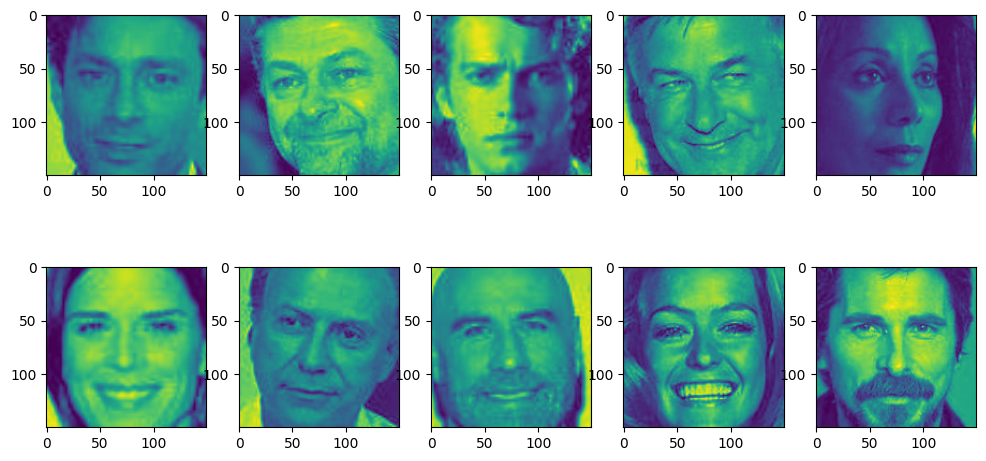

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB') #########

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize the image to a specific size
    transforms.Grayscale(),
    #transforms.CenterCrop(150),
    transforms.ToTensor()  # Convert image to tensor
])


#Assign keys
class_labels = celebrities_dict.values()
class_labels_map = {}


# Create the custom dataset
train_dataset = CustomDataset(train_filenames_list, train_labels_list, transform=transform)

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=400, shuffle=False) #PROVAR AUGMENTAR BACTHSIZE

# Create the custom dataset
test_dataset = CustomDataset(test_filenames_list, test_labels_list, transform=transform)

# Create the dataloader
test_loader = DataLoader(test_dataset, batch_size=400, shuffle=False) #PROVAR AUGMENTAR BACTHSIZE

print('TRAIN DATASET EXAMPLES')
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()} --> [num_images, channels, width, height]")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 5, figsize=(12, 6))
for r in range(0, 2):
  for c in range(0, 5):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(transforms.ToPILImage()(img))
    axarr[r, c].set_title(class_labels_map.get(str(label.item())))
    indx+=1


# CNN Architecture

In [ ]:
import torch.nn as nn

class ReducedIdEstimationModel(nn.Module):
    def __init__(self, num_classes):
        super(ReducedIdEstimationModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # Removed one Conv2d layer to reduce parameters
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 9 * 9, 128),  # Corrected input size based on the last layer's output
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

results_path = '/content/drive/MyDrive/Analisi Gestos i Cares/model/output'


#Train function with accumulation steps to try to reduce the running time
def train(CNN, train_loader,test_loader,optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', accumulation_steps=10):
  print('Training the CNN')
  CNN.train() # Set the model in train mode
  total_step = len(train_loader)
  losses_list = []
  losses_list_test = []
  w = [1]*80
  class_weights = torch.Tensor(w).to(device)

  criterion = nn.CrossEntropyLoss(weight=class_weights)

  # Iterate over epochs
  for epoch in range(num_epochs):
      print('epoch', epoch)
      loss_avg = 0
      nBatches = 0
      accumulation_loss = 0

      # Iterate over batches
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = CNN(images)
          loss = criterion(outputs, labels)

          # Backward pass
          loss.backward()

          # Accumulate gradients
          accumulation_loss += loss.item()

          if (i + 1) % accumulation_steps == 0:
              optimizer.step()
              optimizer.zero_grad()
              loss_avg += accumulation_loss / accumulation_steps
              accumulation_loss = 0
              nBatches += 1

              if (i + 1) % 100 == 0:
                  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                      epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

      torch.cuda.empty_cache()

      # Perform the final update if there are remaining accumulated gradients
      if accumulation_loss > 0:
          optimizer.step()
          optimizer.zero_grad()
          loss_avg += accumulation_loss / accumulation_steps
          nBatches += 1

      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
          epoch + 1, num_epochs, i + 1, total_step, loss_avg / nBatches))

      # aqui fer el tsting
      accuracy, loss_test = test(CNN, test_loader,criterion)
      losses_list_test.append(loss_test.item())
      losses_list.append(loss_avg / nBatches)
      torch.save(CNN.state_dict(), results_path + '/' + model_name)

      print("Epoch",epoch,"loss",loss_avg / nBatches,"loss_val",loss_test.item(),"Accuracy_test",accuracy)

  return losses_list,losses_list_test


# Test funcion
def test(CNN, test_loader,criterion):
  with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # compare with the ground-truth
            total_loss += loss
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total, total_loss/len(test_loader)



In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
num_classes = len(celebrities_dict.keys())
print(num_classes)

#Train MyModel
red_id_model = ReducedIdEstimationModel(num_classes)

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(red_id_model.parameters(), lr=learning_rate, weight_decay=0.09)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
red_id_model = red_id_model.to(device)
losses_list1,losses_list_test = train(red_id_model, train_loader,test_loader, optimizer, num_epochs=100, model_name='reduced_100epochs_batch400_resize150_conv64.ckpt', device=device)

print('Number of parameters:', sum(p.numel() for p in red_id_model.parameters()))

80
Training the CNN
epoch 0
Epoch [1/100], Step [6/6], Loss: 2.6322
Epoch 0 loss 2.6321855068206785 loss_val 4.368322849273682 Accuracy_test 1.7326732673267327
epoch 1
Epoch [2/100], Step [6/6], Loss: 2.6305
Epoch 1 loss 2.630496597290039 loss_val 4.35881233215332 Accuracy_test 1.7326732673267327
epoch 2
Epoch [3/100], Step [6/6], Loss: 2.6296
Epoch 2 loss 2.629646158218384 loss_val 4.348359107971191 Accuracy_test 1.2376237623762376
epoch 3
Epoch [4/100], Step [6/6], Loss: 2.6282
Epoch 3 loss 2.628179407119751 loss_val 4.393796443939209 Accuracy_test 1.4851485148514851
epoch 4
Epoch [5/100], Step [6/6], Loss: 2.6273
Epoch 4 loss 2.627328634262085 loss_val 4.362605094909668 Accuracy_test 1.9801980198019802
epoch 5
Epoch [6/100], Step [6/6], Loss: 2.6276
Epoch 5 loss 2.627630853652954 loss_val 4.340950965881348 Accuracy_test 1.2376237623762376
epoch 6
Epoch [7/100], Step [6/6], Loss: 2.6252
Epoch 6 loss 2.6251500129699705 loss_val 4.372889041900635 Accuracy_test 1.4851485148514851
epoch 

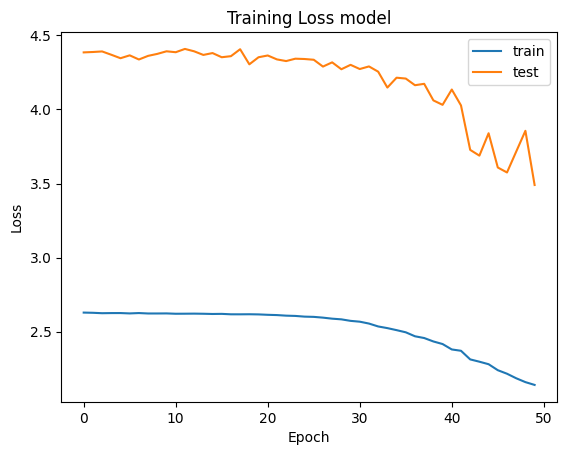

In [ ]:
plt.plot(losses_list1,label="train")
plt.plot(losses_list_test,label="test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss model')
# plt.savefig('/content/drive/MyDrive/DeepLearning_2023/Final Project/plots/PROVA_COLOR_10epochs_.2losses.png')
plt.show()

# Checking Model Performance

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = IdEstimationModel(80)
model.load_state_dict(torch.load('/content/drive/MyDrive/Analisi Gestos i Cares/model/output_m/50epochs_batch400_resize150_conv64.ckpt'))
model.cuda()

w = [1]*80
class_weights = torch.Tensor(w).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

acc = test(model, test_loader, criterion)
print('Accuracy of the Model: ' + str(acc))

Accuracy of the Model: (17.07920792079208, tensor(3.1056, device='cuda:0'))


### Plotting Confusion Matrix

In [ ]:
# Generating predictions from the model above.
model = model.to(device)
model.eval()

predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probabilities = torch.softmax(logits, dim=1)
        batch_predictions = torch.argmax(probabilities, dim=1)
        predicted_labels.extend(batch_predictions.tolist())

'''final_cnn_pred = model.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)'''

'final_cnn_pred = model.predict(test_dataset)\nfinal_cnn_pred = final_cnn_pred.argmax(axis=-1)'

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, predicted_labels)
conf_mat

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 3]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    '''
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")'''

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    # pltig(f'/content/drive/MyDrive/DeepLearning_2023/Final Project/dl_nmm/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


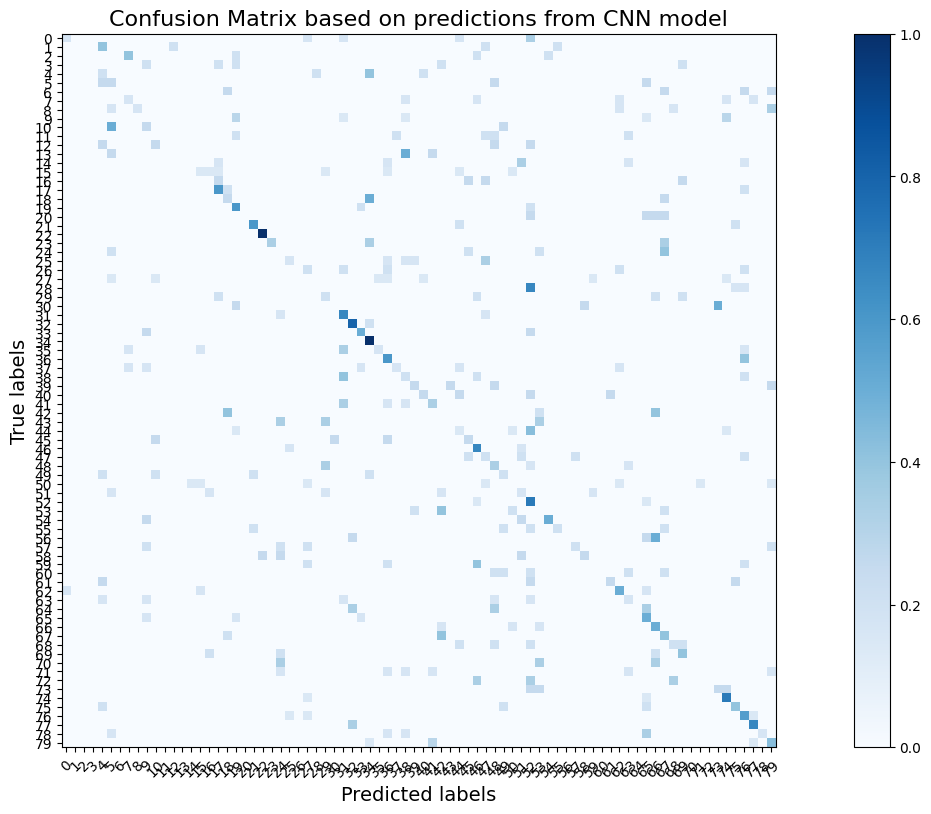

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = list(range(80))
cm_plot_labels = [str(a) for a in cm_plot_labels]

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="fleinal_cnn_conf_mat_norm"
                     )

plt.show()